In [ ]:
# !/opt/homebrew/bin/python3 -m pip3 install ipykernel -U --user --force-reinstall
# !pip install pytesseract
# !pip install pillow
# !pip install opencv-python
# !pip install imutils
# !pip install matplotlib
# !pip install torch
# !pip install easyocr
# !pip install paddlepaddle
# !pip install paddleocr
# !pip install https://github.com/pymupdf/PyMuPDF/archive/master.tar.gz

In [2]:
from os import remove
from os.path import normcase
from os.path import normpath
from os.path import realpath
from tempfile import NamedTemporaryFile
from time import sleep

In [ ]:
tesseract_cmd = ''

In [1]:
import cv2
import imutils
from imutils.perspective import four_point_transform


original_img = cv2.imread('./ocr_test.jpeg', cv2.IMREAD_COLOR)
img = original_img.copy()
img = imutils.resize(img, width=500)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5,), 0)
edged = cv2.Canny(blurred, 75, 200)

# cv2.imshow("gray", gray)
# cv2.imshow("blurred", blurred)
# cv2.imshow("edged", edged)

cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

receiptCnt = None
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    if len(approx) == 4:
        receiptCnt = approx
        break

if receiptCnt is None:
    raise Exception(("Outline not found"))

output = img.copy()
cv2.drawContours(output, [receiptCnt], -1, (255, 0, 0), 3)
cv2.imshow("receipt Outline", output)
cv2.waitKey()
cv2.destroyAllWindows()

2024-06-14 13:04:22.203 Python[990:6988] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


In [15]:
cv2.imshow("gray", edged)
cv2.waitKey()
cv2.destroyAllWindows()

2024-06-11 16:46:54.380 Python[1996:19129] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


## Tesseract

In [3]:
import pytesseract
from PIL import Image
import cv2
import numpy as np

# 이미지 로드 및 전처리
image_path = './paddle_test.jpeg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 해상도 증가
# image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

# 이진화
_, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# PIL 이미지로 변환
binary_image = Image.fromarray(binary_image)

# Tesseract 설정 및 한글 인식
custom_config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(binary_image, lang='kor+eng', config=custom_config)

print(text)

고 객 번 호 、 000

고 객 이름 : 0

날 _ 짜 : 2028-08-15 ~~
[ 동 물 명 : 루 시 ]

진 료 (490, 600)

진 료 비 / 상 담 비 1 11,000

고뺨홀소첨롤쇠 } 스 / 전 해 질 ㅣ 」

× 혈 액 검 사 - 혈 맥 가 스 / 전 ㅎ

검 사 (48 ㄴ 80) ㅣ 55,000

입 원 - 수 액 주 입 장 치 ([451

01 0400) 113,200

입 원 - 수 맥 처 치 (15 2069 미

만 ) ㅣ 55,000

입 원 환 자 모 니 터 링 (HR/RR/BT

/BP) ] ㅣ 55,000

이원 바츰중자르실 0005 。 .

2069 미 만 7,000

주 사 - SC/IH/1V, 10^2069 미 .

o} 59,
입 원 (50,000 . 400
" ※ 혈 맥 걸 사 - 000 (Procyte) 1 50,000

라5 갸 되 어 있 는 항 복 은 비 과 세 입 니 다 .
총 금 액 : 540, 600
맣 팎룰륭회계 105, 000
과 세 품 목 힙 435, 0
과^1|롤목에포헐*된부가세 39, 688
결 제 금 맥 함 계 540, 600
디으 그 애
청 구 2% a0, 600
발 행 일 : 2023-08-15 16:48:00



## EasyOCR

In [6]:
import imutils.perspective
from matplotlib import pyplot as plt
from easyocr import Reader
import random
import cv2
import numpy as np
from PIL import ImageFont, ImageDraw, Image

In [24]:
def plt_imshow(title='image', img=None, figsize=(8, 5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i+1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()

    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()


def make_scan_image(image, width, ksize=(5, 5), min_threshold=75, max_threshold=200):
    image_list_title = []
    image_list = []

    image = imutils.resize(image, width=width)
    ratio = original_img.shape[1] / float(image.shape[1])

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, ksize, 0)
    edged = cv2.Canny(blurred, min_threshold, max_threshold)

    image_list_title = ['gray', 'blurred', 'edged']
    image_list = [gray, blurred, edged]

    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    findCnt = None

    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        if len(approx) == 4:
            findCnt = approx
            break

    if findCnt is None:
        raise Exception(("Outline not found"))
    
    output = image.copy()
    cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)

    image_list_title.append('Outline')
    image_list.append(output)

    transform_image = four_point_transform(original_img, findCnt.reshape(4, 2) * ratio)

    plt_imshow(image_list_title, image_list)
    plt_imshow("Transform", transform_image)

    return transform_image


def putText(cv_img, text, x, y, color=(0, 0, 0)):
    img = Image.fromarray(cv_img)

    draw = ImageDraw(img)

    return cv_img

In [ ]:
url = 'https://image.kmib.co.kr/online_image/2022/1106/2022110210513183171_1667353891_0017634771.jpg'

image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
original_img = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)
plt_imshow("original_img", original_img)

receipts = make_scan_image(original_img, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)

In [5]:
langs = ['ko', 'en']

original_img = cv2.imread('./paddle_test.jpeg', cv2.COLOR_BGR2GRAY)

reader = Reader(lang_list=langs)
results = reader.readtext(original_img, detail=0)

results

['고객',
 '헌혼',
 '고객',
 '틈',
 '날',
 '짜',
 '2023-08-15',
 '[',
 ' : 루시 ]',
 '진',
 '돌물명0; &@',
 '11,000',
 '짚름비소트',
 '압산소치로',
 '165,0OO',
 '#혈액결사-혈액가스전해질',
 '검사 (ABL8O)',
 '1',
 '55,OOO',
 '입원',
 '수액주입장치 (infusi',
 'on pump)',
 '13,200',
 '원',
 '수액처치 (15~2Okg미l',
 '월',
 '55 0OO',
 '원환자 모니터림 (HRIRRIBT',
 'IEP)',
 '55, ODO',
 '입원',
 '집중치료실 (ICU) (15',
 '20kg미만)',
 '77,000',
 '주사',
 'SC/IMIV,',
 '10-2Okg미|',
 '6',
 '59,400',
 '입',
 '화',
 '(50,OOO)',
 '*혈액증사',
 '때 (Procyte)',
 '50OOO',
 'm표지가 되어 있든 향록흔 비과제 입나다',
 '금 액',
 '540,600',
 ';교제월목합계',
 '105, 0OO',
 '목합계',
 '435,600',
 '콤플렉주@부부가',
 '39,600',
 '540,600',
 '청구 금액;',
 'E0,f0',
 '밭 행 일',
 ':',
 '2023-08-15 16:48:00']

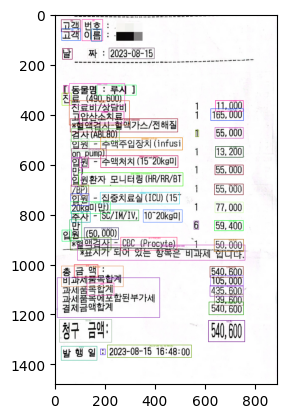

In [8]:
reader = Reader(['ko','en']) # need to run only once to load model into memory
result = reader.readtext('./paddle_test.jpeg')

img    = cv2.imread('./paddle_test.jpeg')

img = Image.fromarray(img)
# font = ImageFont.truetype("fonts/HMKMRHD.TTF",20)
draw = ImageDraw.Draw(img)

np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(255, 3),dtype="uint8")


for i in result :
    x = i[0][0][0]
    y = i[0][0][1]
    w = i[0][1][0] - i[0][0][0]
    h = i[0][2][1] - i[0][1][1]
    
    color_idx = random.randint(0,255)
    color = [int(c) for c in COLORS[color_idx]]
    
#    cv2.putText(img, str(i[1]), (int((x + x + w) / 2) , y-2), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
#    img = cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
    draw.rectangle(((x, y), (x+w, y+h)), outline=tuple(color), width=2)
    draw.text((int((x + x + w) / 2) , y-2),str(i[1]), fill=tuple(color),)

plt.imshow(img)
plt.show()


In [ ]:
original_img = cv2.imread('./ocr_test.jpeg', cv2.IMREAD_COLOR)
img = original_img.copy()
img = imutils.resize(img, width=500)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edge = cv2.Canny(blurred, 50, 150)

contours = cv2.findContours(edge.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

for i in contours:
    length = cv2.arcLength(i, True)
    approx = cv2.approxPolyDP(i, 0.02 * length, True)

    if len(approx) == 4:
        contourCnt = approx
        break

src_pts = np.array(
    [[approx[0][0][0], approx[0][0][1]],
    [approx[1][0][0], approx[1][0][1]],
    [approx[2][0][0], approx[2][0][1]],
    [approx[3][0][0], approx[3][0][1]]]).astype(np.float32)

w = 300
h = 400

dst_pts = np.array([[0, 0],
                    [0, h-1],
                    [w-1, h-1],
                    [w-1, 0]]).astype(np.float32)

pers_mat = cv2.getPerspectiveTransform(src_pts, dst_pts)
src_transform = cv2.warpPerspective(img, pers_mat, (w, h))

_, src_binary = cv2.threshold(src_transform, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# src_filtering = cv2.bilateralFilter(src_binary, -1, 10, 5)

# kernel = np.ones((3, 1), np.unit8)
# src_morphology = cv2.morphologyEx(src_filtering, cv2.MORPH_OPEN, kernel)

# src_morphology
src_binary

In [ ]:
import cv2, os
import numpy as np

img_path = './ocr_test.jpeg'
filename, ext = os.path.splitext(os.path.basename(img_path))
ori_img = cv2.imread(img_path)

src = []

# mouse callback handler
def mouse_handler(event, x, y, flags, param):
  if event == cv2.EVENT_LBUTTONUP:
    img = ori_img.copy()

    src.append([x, y])

    for xx, yy in src:
      cv2.circle(img, center=(xx, yy), radius=5, color=(0, 255, 0), thickness=-1, lineType=cv2.LINE_AA)

    cv2.imshow('img', img)

    # perspective transform
    if len(src) == 4:
      src_np = np.array(src, dtype=np.float32)

      width = max(np.linalg.norm(src_np[0] - src_np[1]), np.linalg.norm(src_np[2] - src_np[3]))
      height = max(np.linalg.norm(src_np[0] - src_np[3]), np.linalg.norm(src_np[1] - src_np[2]))

      dst_np = np.array([
        [0, 0],
        [width, 0],
        [width, height],
        [0, height]
      ], dtype=np.float32)

      M = cv2.getPerspectiveTransform(src=src_np, dst=dst_np)
      result = cv2.warpPerspective(ori_img, M=M, dsize=(width, height))

      cv2.imshow('result', result)
      cv2.imwrite('./result/%s_result%s' % (filename, ext), result)

# main
cv2.namedWindow('img')
cv2.setMouseCallback('img', mouse_handler)

cv2.imshow('img', ori_img)
# cv2.waitKey(0)

if cv2.waitKey() == 27:
  cv2.destroyAllWindows()


## PaddleOCR

In [4]:
from paddleocr import PaddleOCR, draw_ocr
from PIL import Image, ImageDraw, ImageFont
import cv2 #opencv
from matplotlib import pyplot as plt # plot images
import os # folder directory navigation
import numpy as np
os.environ['KMP_DUPLICATE_LIB_OK']='True'


ocr_model = PaddleOCR(lang='korean')
img_path = './paddle_test.jpeg'
image = Image.open(img_path)
image_np = np.array(image)
result = ocr_model.ocr(image_np, cls=True)

result

# result = ocr_model.ocr(img_path)

# result

[2024/06/17 14:04:18] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/heonyounglee/.paddleocr/whl/det/ml/Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/heonyounglee/.paddleocr/whl/rec/korean/korean_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_n